[View in Colaboratory](https://colab.research.google.com/github/mogamin/chainer-examples/blob/master/chainer_PotatoChips_Classification.ipynb)

In [0]:
# potatoChipsデータセットのダウンロード
![ ! -e ./data ] && curl -L "https://rebrand.ly/dllab2018-hackathon-cv" -o data.tar.gz && gzip -d -c data.tar.gz | tar xf -

# chainer,chainercv,cudaののセットアップ
!apt-get install -y -qq libcusparse8.0 libnvrtc8.0 libnvtoolsext1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip install cupy-cuda80==4.3.0 
!pip install chainer==4.3.0
!pip install chainercv

In [1]:
# GPU環境の確認
import chainer
print('GPU availability:', chainer.cuda.available)
print('cuDNN availablility:', chainer.cuda.cudnn_enabled)

# クリーニング
!rm -rf result/

GPU availability: True
cuDNN availablility: True


In [0]:
# 乱数表の固定化
import random
import numpy as np

RANDOM_SEED = 0
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if chainer.cuda.available:
    chainer.cuda.cupy.random.seed(RANDOM_SEED)

# 実行時間の生成
import datetime
now = (datetime.datetime.now() + datetime.timedelta(hours=+9)).strftime('%Y%m%d-%H%M%S')

In [0]:
# 画像データの前処理変換
import chainer
from chainercv.transforms import resize
from chainercv.transforms import random_flip
from chainercv.transforms import random_sized_crop
from chainercv.transforms import random_rotate

class ImageResizeTransform(object):
    def __call__(self, in_data):
        img, label = in_data
        img = resize(img, (224, 224))
        return img, label

class ImageRandomTransform(object):
    def __call__(self, in_data):
        img, label = in_data
        _, H, W = img.shape
        img = random_sized_crop(img)
        img = resize(img, (224, 224))
        img = random_flip(img, x_random=True)
        img = random_rotate(img)
        return img, label      

In [0]:
import chainer.links as L
import chainer.functions as F
from chainercv.links import VGG16

# VGG16でpretrained_modelを組み入れるモデル
class PotatoCNN_VGG16_pretrained(chainer.Chain):
  def __init__(self, pretrained_model, n_class=9):
    super(PotatoCNN_VGG16_pretrained, self).__init__()
    with self.init_scope():
      self.base = VGG16(pretrained_model=pretrained_model)
      self.base.pick = 'pool5'
      self.fc1 = L.Linear(None, 4096)
      self.fc2 = L.Linear(None, 4096)
      self.fc3 = L.Linear(None, n_class)
  
  def __call__(self, x):
    h = self.base(x)
    h.unchain()
    h = F.relu(self.fc1(h))
    h = F.relu(self.fc2(h))
    return self.fc3(h)

# VGG16を参考にしたモデル
class PotatoCNN_VGG16(chainer.Chain):
  def __init__(self, n_class=9):
    super(PotatoCNN_VGG16, self).__init__()
    with self.init_scope():
      self.conv1_1 = L.Convolution2D(3, 64, 3, 1, 1)
      self.conv1_2 = L.Convolution2D(64, 64, 3, 1, 1)
      self.conv2_1 = L.Convolution2D(64, 128, 3, 1, 1)
      self.conv2_2 = L.Convolution2D(128, 128, 3, 1, 1)
      self.conv3_1 = L.Convolution2D(128, 256, 3, 1, 1)
      self.conv3_2 = L.Convolution2D(256, 256, 3, 1, 1)
      self.conv3_3 = L.Convolution2D(256, 256, 3, 1, 1)
      self.conv4_1 = L.Convolution2D(256, 512, 3, 1, 1)
      self.conv4_2 = L.Convolution2D(512, 512, 3, 1, 1)
      self.conv4_3 = L.Convolution2D(512, 512, 3, 1, 1)
      self.conv5_1 = L.Convolution2D(512, 512, 3, 1, 1)
      self.conv5_2 = L.Convolution2D(512, 512, 3, 1, 1)
      self.conv5_3 = L.Convolution2D(512, 512, 3, 1, 1)
      self.fc6 = L.Linear(512 * 7 * 7, 4096)
      self.fc7 = L.Linear(4096, 4096)
      self.fc8 = L.Linear(4096, n_class)
  
  def __call__(self, x):
    print(x.shape)
    h = F.relu(self.conv1_1(x))
    h = F.relu(self.conv1_2(h))
    h = F.max_pooling_2d(h, ksize=2)
    h = F.relu(self.conv2_1(h))
    h = F.relu(self.conv2_2(h))
    h = F.max_pooling_2d(h, ksize=2)
    h = F.relu(self.conv3_1(h))
    h = F.relu(self.conv3_2(h))
    h = F.relu(self.conv3_3(h))
    h = F.max_pooling_2d(h, ksize=2)
    h = F.relu(self.conv4_1(h))
    h = F.relu(self.conv4_2(h))
    h = F.relu(self.conv4_3(h))
    h = F.max_pooling_2d(h, ksize=2)
    h = F.relu(self.conv5_1(h))
    h = F.relu(self.conv5_2(h))
    h = F.relu(self.conv5_3(h))
    h = F.max_pooling_2d(h, ksize=2)
    h = F.relu(self.fc6(h))
    h = F.relu(self.fc7(h))
    return self.fc8(h)  

# MLPモデル
class PotatoMLP(chainer.Chain):
  def __init__(self, n_class=9):
    super(PotatoMLP, self).__init__()
    with self.init_scope():
      self.fc1 = L.Linear(None, 224)
      self.fc2 = L.Linear(None, 224)
      self.fc3 = L.Linear(None, 224)
      self.fc4 = L.Linear(None, 224)
      self.fc5 = L.Linear(None, 224)
      self.fc6 = L.Linear(None, n_class)
  
  def __call__(self, x):
    h = F.relu(self.fc1(x))
    h = F.relu(self.fc2(h))
    h = F.relu(self.fc3(h))
    h = F.relu(self.fc4(h))
    h = F.relu(self.fc5(h))
    return self.fc6(h)  

In [0]:
# オプティマイザの生成
from chainer import optimizer

def optimizer_adam(model):
  optimizer = chainer.optimizers.Adam()
  optimizer.setup(model)
  return optimizer

def optimizer_momentumSGD(model):
  optimizer = chainer.optimizers.MomentumSGD(lr=0.001, momentum=0.9).setup(model)
  return optimizer
#  for param in model.params():
#    if param.name != 'beta' and param.name != 'gamma':
#        param.update_rule.add_hook(chainer.optimizer.WeightDecay(0.0001))
#  return optimizer

In [0]:
## PATTERN-1
model = L.Classifier(PotatoCNN_VGG16_pretrained(pretrained_model='imagenet'))
optimizer = optimizer_momentumSGD(model)
#optimizer = optimizer_adam(model)

## PATTERN-2
#model = L.Classifier(PotatoCNN_VGG16())
#optimizer = optimizer_momentumSGD(model)

## PATTERN-3
#model = L.Classifier(PotatoMLP())
#optimizer = optimizer_momentumSGD(model)

In [0]:
# GPU/CPU処理時の設定
if chainer.cuda.available == True:
  GPUID=0
  xp = chainer.cuda.cupy
  chainer.cuda.Device(GPUID).use()
  model.to_gpu(GPUID)
else:
  GPUID=-1
  xp = np

In [8]:
from chainer.datasets import LabeledImageDataset
from chainer.datasets import TransformDataset
from chainer.training import extensions

BATCHSIZE=16
EPOCH=3

# データのロード
train = LabeledImageDataset('data/train/train_labels.txt', root='data/train/images/')
train = TransformDataset(train, ImageResizeTransform())
valid = LabeledImageDataset('data/valid/valid_labels.txt', root='data/valid/images/')
valid = TransformDataset(valid, ImageResizeTransform())

# train,valid用のイテレータを生成
train_iter = chainer.iterators.SerialIterator(train, BATCHSIZE)
valid_iter = chainer.iterators.SerialIterator(valid, BATCHSIZE, repeat=False, shuffle=False)

updater = chainer.training.StandardUpdater(train_iter, optimizer, device=GPUID)
trainer = chainer.training.Trainer(updater, (EPOCH, 'epoch'), out='result/potato')

log_interval = 0.1, 'epoch'
val_interval = 0.1, 'epoch'

# ラーニングレートのシフト設定
#trainer.extend(extensions.ExponentialShift('lr', 0.1), trigger=chainer.training.triggers.ManualScheduleTrigger([10], 'epoch'))
trainer.extend(extensions.ExponentialShift('lr', 0.1), trigger=(1, 'epoch'))

# validデータの検証設定
trainer.extend(extensions.Evaluator(valid_iter, model, device=GPUID), trigger=val_interval, name='val')

# ログ設定
trainer.extend(extensions.observe_lr(), trigger=(1, 'iteration'))
trainer.extend(extensions.LogReport(trigger=log_interval))
trainer.extend(extensions.PrintReport(['iteration', 'epoch', 'elapsed_time', 'lr', 'main/loss','val/main/loss', 'main/accuracy', 'val/main/accuracy']), trigger=log_interval)
#trainer.extend(extensions.ProgressBar(update_interval=500))

trainer.run()

iteration   epoch       elapsed_time  lr          main/loss   val/main/loss  main/accuracy  val/main/accuracy
66          0           73.8686       0.001       20.8051     3.63694        0.315341       0.473              
132         0           146.229       0.001       3.67308     5.9033         0.553977       0.4855             
198         0           218.656       0.001       3.57829     3.03289        0.571023       0.5305             
264         0           291.091       0.001       1.72281     1.072          0.574811       0.6725             
330         0           363.434       0.001       1.06004     1.39924        0.694129       0.7155             
396         0           435.796       0.001       0.910047    1.00286        0.754735       0.704              
461         0           507.756       0.001       0.722008    0.685148       0.785577       0.7945             
527         0           580.213       0.001       0.545212    0.476047       0.840909       0.863         

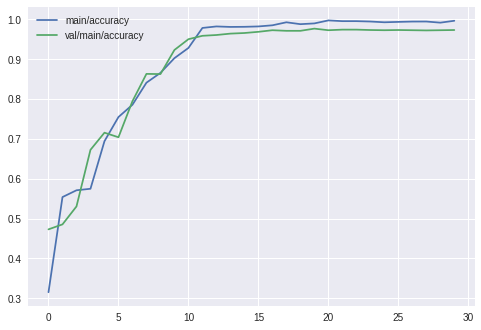

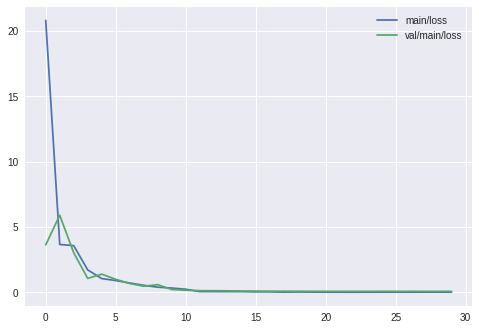

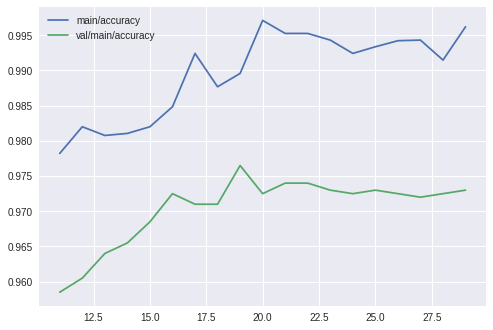

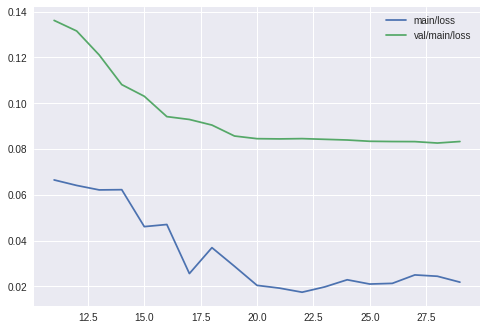

In [84]:
import json
import pandas as pd
with open('result/potato/log') as f:
  result = pd.DataFrame(json.load(f)).interpolate()

result[['main/accuracy','val/main/accuracy']].plot()
result[['main/loss','val/main/loss']].plot()

result = result.iloc[11:,:]
result[['main/accuracy','val/main/accuracy']].plot()
result[['main/loss','val/main/loss']].plot()

In [10]:
import os

# 学習したモデルに対してテストデータセットで検証をする
test = LabeledImageDataset('data/test/test_labels.txt', root='data/test/images')
test = TransformDataset(test, ImageResizeTransform())
test_iter = chainer.iterators.SerialIterator(test, BATCHSIZE, repeat=False, shuffle=False)
test_evaluator = extensions.Evaluator(test_iter, model, device=GPUID)
results = test_evaluator()

msg = 'Test loss\t:{}\n'.format(results['main/loss']) + 'Test accuracy\t:{}'.format(results['main/accuracy'])
print(msg)
print(msg, file=open(os.path.join('./result/potato/', 'test_result.txt'), 'w'))

Test loss	:0.07557979
Test accuracy	:0.9764306


In [0]:
# 学習したモデルをGPU形式のまま保存
chainer.serializers.save_npz(os.path.join('./', 'model_potato_{}_gpu.npz'.format(now)), model)

In [12]:
# validデータより誤認識した一覧を出力
from PIL import Image
from chainercv.transforms import resize
from chainercv.utils import read_image

def predict_potato(path, filename):
  image_orig = read_image(path+filename, color=True)
  image = resize(image_orig, (224, 224))
  image = image.reshape((1,) + image.shape) # reshape 3D to 4D
  if chainer.cuda.available == True:
    image = chainer.cuda.to_gpu(image)
  
  prediction = F.softmax(model.predictor(image))
  y_hat = np.argmax(prediction.data)
  return y_hat, image_orig
  

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_csv('data/valid/valid_labels.txt', delimiter=' ', header=None)

incorrect = 0
for index, row in df.iterrows():
  y_hat, _ = predict_potato('data/valid/images/', row[0])
  if y_hat != row[1]:
    print('predicted={}, but y={}, {}'.format(y_hat, row[1], row[0]))
    incorrect += 1

print('accuracy={}, data_count={}, incorrect_count={}'.format((len(df)-incorrect)/len(df), len(df), incorrect))

predicted=6, but y=7, 4901330532918_14_U30_240.jpg
predicted=7, but y=6, 4901330532734_18_U30_090.jpg
predicted=7, but y=6, 4901330532734_26_U30_105.jpg
predicted=6, but y=7, 4901330532918_7_D30_090.jpg
predicted=2, but y=3, 4901330523121_8_U00_165.jpg
predicted=4, but y=5, 4901330523183_20_U30_255.jpg
predicted=5, but y=6, 4901330532734_66_D30_030.jpg
predicted=6, but y=7, 4901330532918_17_U30_075.jpg
predicted=3, but y=8, 4901330534516_65_U00_315.jpg
predicted=4, but y=7, 4901330532918_19_U00_315.jpg
predicted=4, but y=2, 4901330503284_34_U00_150.jpg
predicted=7, but y=6, 4901330532734_21_U30_105.jpg
predicted=5, but y=4, 4901330523176_40_D30_030.jpg
predicted=4, but y=7, 4901330532918_17_U30_315.jpg
predicted=4, but y=5, 4901330523183_2_U00_315.jpg
predicted=1, but y=7, 4901330532918_8_D30_285.jpg
predicted=8, but y=3, 4901330523121_16_U00_225.jpg
predicted=8, but y=7, 4901330532918_7_U00_315.jpg
predicted=6, but y=5, 4901330523183_6_U00_300.jpg
predicted=4, but y=2, 4901330503284_3

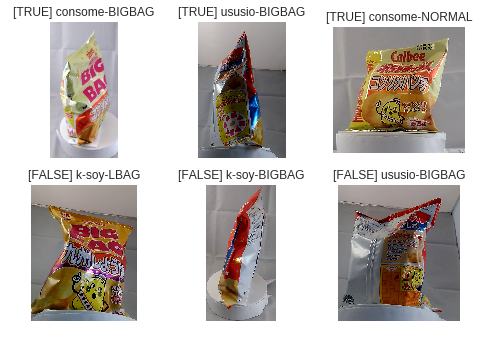

In [83]:
# 学習モデルを使って一つ一つ画像分類する
label_names = (
    'ususio-BIGBAG','ususio-LBIG','ususio-NORMAL',
    'consome-NORMAL','consome-LBIG','consome-BIGBAG',
    'k-soy-BIGBAG','k-soy-LBAG','k-soy-NORMAL')

plot_pos = 1
image_list = [
    ('4901330523183_26_U30_075.jpg','5'), # TRUE
    ('4901330502911_16_D30_105.jpg','0'), # TRUE
    ('4901330523121_15_U00_345.jpg','3'), # TRUE
    ('4901330532734_14_D30_015.jpg','6'), # FALSE
    ('4901330502911_20_U30_270.jpg','0'), # FALSE
    ('4901330502928_19_D30_150.jpg','1'), # FALSE
]
for item, item_t in image_list:
  y_hat, _ = predict_potato('data/valid/images/', item)
  image = Image.open('data/valid/images/'+ item)
  plt.subplot(2, 3, plot_pos)
  plt.axis("off")
  jud = "TRUE" if int(y_hat) == int(item_t) else "FALSE"
  plt.title('[{}] {}'.format(jud, label_names[int(y_hat)]))
  plot_pos += 1
  plt.imshow(np.array(image))
